<a href="https://colab.research.google.com/github/kdj0712/study_data_analytics/blob/main/docs/quests/CDAs/CDA_continual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## X(연속형) / Y(연속형) 케이스

### 사전 작업

In [ ]:
# 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용
import matplotlib.font_manager as fm
# 설치된 폰트 중 'NanumGothic' 찾기
for font in fm.fontManager.ttflist:
    if 'NanumGothic' in font.name:
        plt.rcParams['font.family'] = font.name
        break
plt.rcParams['axes.unicode_minus'] = False
import numpy as np

In [2]:
df_fruitstores = pd.read_csv('/content/drive/MyDrive/data_analytics/CSV파일/fruitstore_saleshistory.csv')
df_fruitstores[:2]

,공급일자,요일,공급월,공급주차,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,주소-구,주소-동,성별,연령,연령대,구매금액,구매매장,반품_원거래일자,구매시각
0,2018-01-02,화,1,1,272369856,정상회원,과실,과일,사과,사과/유(1.5kg),1.0,수지구,풍덕천동,여,45.0,40대,22207,매장C,NaN,10:04
1,2018-01-02,화,1,1,1506656256,정상회원,채소,버섯,느타리버섯,느타리버섯(300g),1.0,수지구,풍덕천동,여,36.0,30대이하,4977,매장C,NaN,10:05


## 계절 과일의 판매 수익(Y)에 시간(X)에 따른 추세가 있습니까?
 - 분석 방법: 시계열 분석을 사용하여 계절 과일의 판매 수익이 시간에 따라 어떤 추세, 계절성, 순환 패턴을 보이는지 식별합니다. 이를 위해 ARIMA 모델과 같은 기법을 적용할 수 있습니다.


### 분석 내용 : 계절 과일의 판매 수익(Y)에 시간(X)에 따른 추세가 있는가?
- 귀무 가설 : 계절 과일의 판매 수익에 시간에 따른 추세가 없다.
- 대립 가설 : 계절 과일의 판매 수익에 시간에 따른 추세가 있다.


In [3]:
# 로딩 한 데이터 중 판매 품목이 과일인 항목만 추출하여 별도의 데이터 프레임 생성
df_quest1 = df_fruitstores
conditions_1 = '물품중분류 == "과일"'
df_quest2 = df_quest1.query(conditions_1)
df_quest2[:2]

,공급일자,요일,공급월,공급주차,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,주소-구,주소-동,성별,연령,연령대,구매금액,구매매장,반품_원거래일자,구매시각
0,2018-01-02,화,1,1,272369856,정상회원,과실,과일,사과,사과/유(1.5kg),1.0,수지구,풍덕천동,여,45.0,40대,22207,매장C,NaN,10:04
62,2018-01-02,화,1,1,445131904,정상회원,과실,과일,건대추,건대추(500g),1.0,수지구,풍덕천동,여,58.0,50대,22973,매장C,NaN,12:18


In [4]:
# '물품소분류' 컬럼의 값이 과일인 항목의 '물품소분류'컬럼을 통해 해당 과일들의 명칭을 추출
df_quest2['물품소분류'].unique()

array(['사과', '건대추', '귤(조생)', '배', '산딸기', '단감', '참다래', '레몬', '블루베리', '곶감',
       '귤만감', '냉동건조과일', '홍시용감(대봉)', '귤(비가림)', '청매실', '황매실', '복숭아', '자두'],
      dtype=object)

In [5]:
# 일부 오류는 있을 수 있으나, 통상적인 과일들의 제철인 계절별로 분류하는 작업
# 계절 별 과일 종류 배치
categories = {
        '봄' :[
              '딸기','블루베리'
            ],
        '여름' : [
            '복숭아','자두','참다래','블루베리'
            ],
        '가을' : [
          '사과','배','단감','곶감','홍시용감','귤(조생)',
          '귤(비가림)','레몬','청매실','황매실'
          ],
          '겨울' : [
          '건대추','귤(비가림)','귤(조생)','레몬',
          '냉동건조과일','홍시용감'
          ]
}
#'제철'컬럼에 분류하기 위해, '물품소분류' 컬럼에 있는 과일의 이름을 계절별로 확인하고 임시 저장한 뒤, 그 값을 mapping을 통해 '제철'컬럼에 입력한다.
fruit_to_season = {fruit: season for season, fruits in categories.items() for fruit in fruits}
df_quest2.loc[:,'제철'] = df_quest2['물품소분류'].map(fruit_to_season)

<ipython-input-5-890dbc5f7799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quest2.loc[:,'제철'] = df_quest2['물품소분류'].map(fruit_to_season)


In [6]:
# 날짜 계산을 위해 '공급일자'컬럼의 Dtype을 datetime 형태로 변경한 뒤 'Date'컬럼에 저장한다.
df_quest2.loc[:,'Date']= pd.to_datetime(df_quest2['공급일자'],format ="%Y-%m-%")

<ipython-input-6-f5dfb6de910d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quest2.loc[:,'Date']= pd.to_datetime(df_quest2['공급일자'],format ="%Y-%m-%")


In [7]:
# 'Date'컬럼에서 월 정보를 추출하여 'month'컬럼을 생성하여 저장한다.
df_quest2.loc[:,'month'] = df_quest2['Date'].dt.month
# 판매된 날짜 중 월 정보를 바탕으로 계절 정보를 계산
def month_to_season(month):
    if 3 <= month <= 5:
        return '봄'
    elif 6 <= month <= 8:
        return '여름'
    elif 9 <= month <= 11:
        return '가을'
    else:
        return '겨울'

df_quest2['purchase_season'] = df_quest2['month'].apply(month_to_season)
# 계절 정보를 바탕으로 제철인지 아닌지 판단하여,'제철여부'컬럼을 만든 뒤 제처이 맞을 경우에는 'Y' 아닐 경우에는 'N'을 입력하여 해당 컬럼에 저장한다.
df_quest2['제철여부'] = (df_quest2['purchase_season'] == df_quest2['제철']).replace({True: 'Y', False: 'N'})
df_quest2 = df_quest2.drop(['month', 'purchase_season'], axis=1)
df_quest2[:2]

<ipython-input-7-843b6c7e9184>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quest2.loc[:,'month'] = df_quest2['Date'].dt.month
<ipython-input-7-843b6c7e9184>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quest2['purchase_season'] = df_quest2['month'].apply(month_to_season)
<ipython-input-7-843b6c7e9184>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,공급일자,요일,공급월,공급주차,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,...,성별,연령,연령대,구매금액,구매매장,반품_원거래일자,구매시각,제철,Date,제철여부
0,2018-01-02,화,1,1,272369856,정상회원,과실,과일,사과,사과/유(1.5kg),...,여,45.0,40대,22207,매장C,NaN,10:04,가을,2018-01-02,N
62,2018-01-02,화,1,1,445131904,정상회원,과실,과일,건대추,건대추(500g),...,여,58.0,50대,22973,매장C,NaN,12:18,겨울,2018-01-02,Y


In [8]:
# 제철에 구매한 총 매출액과 그렇지 않은 매출액의 총 합계를 계산하여 pivot_table에 저장
df_quest3 = pd.pivot_table(df_quest2, values='구매금액', index='제철여부', aggfunc=np.sum)

In [9]:
df_quest3

,구매금액
제철여부,
N,290742538
Y,44657091


### 제철 여부의 매출 분석을 독립 2표본 t-검정으로 진행
 - 독립 2표본 t-검정은 두 집단의 평균이 통계적으로 차이가 있는지를 판단하는 검정 방법입니다. '제철여부'에 따른 매출이 두 개의 그룹('Y'와 'N')으로 나눌 수 있기 때문에, 이 검정 방법이 적합합니다.
 - t-검정은 표본의 크기나 분산 등에 대한 가정이 크게 필요하지 않아서 실제 데이터 분석에 널리 사용됩니다. 두 그룹의 표본 크기가 다르거나, 두 그룹의 분산이 다른 경우에도 사용할 수 있습니다.
 - 따라서, 이 검정 방법을 통해 '제철여부'에 따른 매출의 차이가 통계적으로 유의미한지를 객관적으로 판단할 수 있습니다. 이 결과를 바탕으로 제철과일의 판매 전략을 개선하거나, 제철이 아닌 과일의 판매를 더욱 활성화하는 등의 결정을 내릴 수 있습니다.
 - from Written

In [10]:
from scipy.stats import ttest_ind
# '제철여부'에 따라 매출 데이터를 두 개의 그룹으로 나눕니다.
group1 = df_quest2.loc[df_quest2['제철여부'] == 'Y', '구매금액']
group2 = df_quest2.loc[df_quest2['제철여부'] == 'N', '구매금액']
# 독립 2표본 t-검정을 수행
t_stat, p_value = ttest_ind(group1, group2)
print("t statistic:", t_stat)
print("p-value:", p_value)

t statistic: -8.312764317702623
p-value: 1.0123572521094248e-16


In [11]:
round(1.0123572521094248e-16,6)

0.0

In [12]:
# 전체 판매 금액 중 제철과일 매출액과 비 제철과일 매출액의 퍼센테이지 비교
total_sales = df_quest2['구매금액'].sum()
season_sales = df_quest2.groupby('제철여부')['구매금액'].sum()
season_sales_ratio = (season_sales / total_sales)*100
print("{}%".format(season_sales_ratio))

제철여부
N    86.685408
Y    13.314592
Name: 구매금액, dtype: float64%


### 매출액 중 제철의 여부 상관 관계는 있는 것으로 보이나 추가 확인을 위해 다른 작업 진행

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# 'Date'를 인덱스로 설정
df_quest2.set_index('Date', inplace=True)

# 판매 수익을 시계열 데이터로 변환
sales_series = df_quest2['구매금액']

# 일별 데이터로 재구성
sales_series = sales_series.resample('D').sum()

# ARIMA 모델 생성 및 학습
model = ARIMA(sales_series, order=(1,1,1))
model_fit = model.fit()

# 예측 결과 출력
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   구매금액   No. Observations:                  180
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2792.998
Date:                Mon, 05 Feb 2024   AIC                           5591.996
Time:                        13:51:47   BIC                           5601.558
Sample:                    01-02-2018   HQIC                          5595.873
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1192      0.073      1.623      0.105      -0.025       0.263
ma.L1         -0.9504      0.033    -28.721      0.000      -1.015      -0.886
sigma2      2.411e+12   3.93e-14   6.13e+25      0.0

In [14]:
df_quest2[:2]

,공급일자,요일,공급월,공급주차,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,...,주소-동,성별,연령,연령대,구매금액,구매매장,반품_원거래일자,구매시각,제철,제철여부
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2018-01-02,화,1,1,272369856,정상회원,과실,과일,사과,사과/유(1.5kg),...,풍덕천동,여,45.0,40대,22207,매장C,NaN,10:04,가을,N
2018-01-02,2018-01-02,화,1,1,445131904,정상회원,과실,과일,건대추,건대추(500g),...,풍덕천동,여,58.0,50대,22973,매장C,NaN,12:18,겨울,Y


### 시계열 분석 모델 중 SARIMAX로 제철여부를 반영하여 시계열 분석 시도

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# '제철여부'컬럼에서 해당 여부의 유무를 숫자형 타입으로 변경하여 저장하기 위한'제철binary' 컬럼 생성
df_quest2['제철_binary'] = df_quest2['제철여부'].map({'Y': 1, 'N': 0})
# '제철 binary' 컬럼을 외생 변수로 설정
exog = df_quest2['제철_binary']
# 판매 수익을 시계열 데이터로 변환
sales_series = df_quest2['구매금액']
# SARIMAX 모델 생성 및 학습
model = SARIMAX(sales_series, exog=exog, order=(1,1,1))
model_fit = model.fit()
# 예측 결과 출력
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   구매금액   No. Observations:                15402
Model:               SARIMAX(1, 1, 1)   Log Likelihood             -172450.395
Date:                Mon, 05 Feb 2024   AIC                         344908.789
Time:                        13:51:59   BIC                         344939.358
Sample:                             0   HQIC                        344918.918
                              - 15402                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
제철_binary  -3733.9179    632.037     -5.908      0.000   -4972.688   -2495.148
ar.L1          0.0012      0.006      0.200      0.842      -0.011       0.013
ma.L1         -0.9793      0.001   -726.687      0.0

#### 제철 과일 판매에 대한 SARIMAX 모델의 결과를 확인해봅시다.
- coef: 각 파라미터의 가중치입니다. '제철_binary'의 가중치는 -3733.9179인데, 이는 제철 과일이 아닐 때 판매 수익이 평균적으로 약3734만큼 감소한다는 것을 의미합니다.
- P>|z|: 각 파라미터의 유의성을 검정하는 p-value입니다. 일반적으로 p-value가 0.05 이하면 해당 파라미터가 통계적으로 유의미하다고 판단합니다. 여기서는 '제철_binary', 'ma.L1'의 p-value가 0.000으로, 이들이 통계적으로 유의미하다고 판단할 수 있습니다.
- sigma^2: 모델의 잔차(residual)의 분산을 의미합니다. 잔차는 모델이 예측한 값과 실제 값의 차이를 나타내며, 이 값이 작을수록 모델의 성능이 좋다고 판단할 수 있습니다.
- Ljung-Box(Q): 잔차의 자기상관을 검정하는 통계량입니다. Prob(Q)가 0.05보다 크면 잔차가 자기상관을 가지지 않는다고 판단합니다. 여기서는 Prob(Q)가 0.99로, 잔차가 자기상관을 가지지 않는다고 판단 수 있습니다.
- Jarque-Bera(JB): 잔차의 정규성을 검정하는 통계량입니다. Prob(JB)가 0.05보다 크면 잔차가 정규분포를 따른다고 판단합니다. 여기서는 Prob(JB)가 0으로, 잔차가 정규분포를 따르지 않는다고 판단할 수 있습니다6. Heteroskedasticity(H): 잔차의 등분산성을 검정하는 통계량입니다. Prob(H)가 0.05보다 크면 잔차가 등분산성을 가진다고 판단합니다. 여기서는 Prob(H)가 0으로, 잔차가 등분산성을 가지지 않는다고 판단할 수 있습니다.
- 이 모델의 결과를 통해, 제철 과일이 아닐 판매 수익이 평균적으로 약 3734만큼 감소한다는 것을 알 수 있습니다. 그러나 여전히 'Covariance matrix is singular or near-singular, with condition number 9.21e+23. Standard errors may be unstable.'라는 경고가 출력되었습니다. 이는 공분 행렬이 특이 행렬이거나 거의 특이 행렬이라는 것을 의미하며, 이 경우 모델의 결과를 신뢰하기 어려울 수 있습니다. 따라서, 다른 파라미터로 모델을 다시 학하거나, 다른 모델을 사용하는 것을 고려해보는 것이 좋습니다.

제공해주신 SARIMAX 모델 결과를 살펴보면, '제철_binary' 변수가 모델에 반영되어 있고 이 변수의 계수는 -3733.9179로 나타나 있습니다. 이는 제철 과일이 아닐 때('제철_binary'가 0일 때) 판매량이 제철 과일일 때('제철_binary'가 1일 때)보다 평균적으로 3733.9179만큼 더 많다는 것을 의미합니다.

또한, 이 변수의 p-value는 0.000으로, 이 변수가 판매량을 예측하는 데 통계적으로 유의미하다는 것을 보여줍니다.

그러나 한 가지 주의할 점은, 이 모델은 '구매금액'이라는 종속변수가 1차 차분을 취한 후의 값에 대한 모델이기 때문에, 실제 '구매금액'에 대한 해석은 주의가 필요합니다. 이 모델은 '구매금액'의 변화량에 대한 모델이라고 볼 수 있습니다.

또한, 모델의 AIC와 BIC 값은 모델의 품질을 나타내는 지표로, 일반적으로 이 값이 작을수록 모델의 품질이 좋다고 판단합니다. 하지만 이 값들은 다른 모델들과 비교할 때 의미가 있으므로, 다른 모델들의 AIC와 BIC 값을 함께 고려해야 합니다.

마지막으로, 'Warnings' 부분에서 'Covariance matrix is singular or near-singular, with condition number 9.21e+23. Standard errors may be unstable.'라는 경고 메시지가 나타나고 있습니다. 이는 모델의 공분산 행렬이 특이행렬 또는 거의 특이행렬이라는 것을 의미하며, 이 경우 표준 오차가 불안정할 수 있다는 경고입니다. 이 문제는 변수 간의 다중공선성 때문에 발생할 수 있으므로, 변수 선택을 재고해 볼 필요가 있습니다.

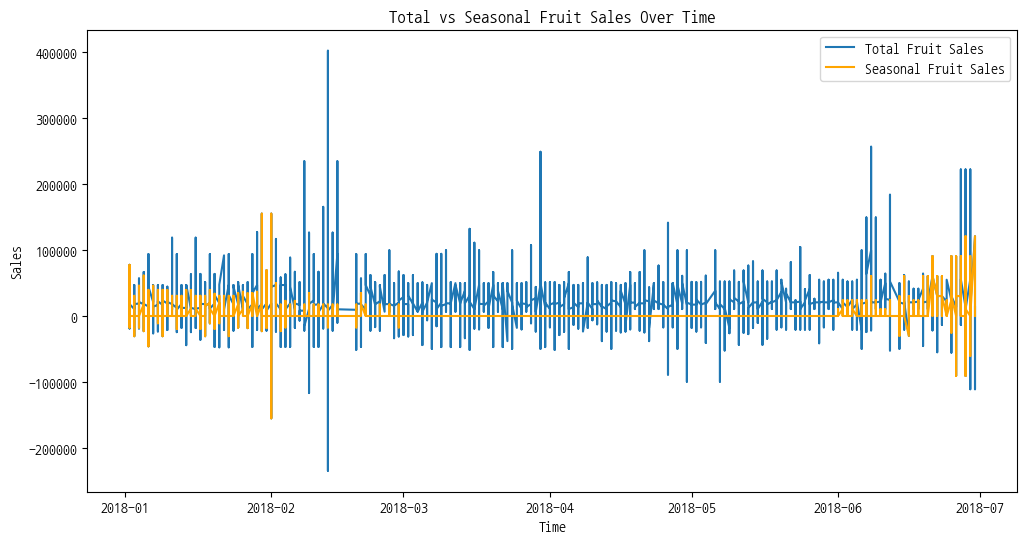

In [16]:
# 제철 과일 판매량 계산
df_quest2['제철 과일 판매량'] = df_quest2['구매금액'] * df_quest2['제철_binary']

# 전체 과일 판매량과 제철 과일 판매량 시각화
plt.figure(figsize=(12,6))
plt.plot(df_quest2['구매금액'], label='Total Fruit Sales')
plt.plot(df_quest2['제철 과일 판매량'], label='Seasonal Fruit Sales', color='orange')
plt.title('Total vs Seasonal Fruit Sales Over Time')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [17]:
# pearson 방식으로 상관계수 검사
import scipy.stats as stats
corr, p_value = stats.pearsonr(df_quest2['제철_binary'], df_quest2['구매금액'])
print("상관계수 : ",corr)
print("p-value : ",p_value)

상관계수 :  -0.06683637935456613
p-value :  1.0123572521092729e-16


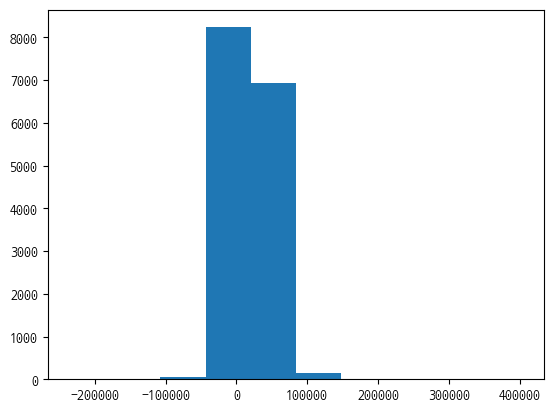

In [18]:
# 두 데이터의 정규 분포 여부 확인 위한 히스토 그램 생성
plt.hist(df_quest2['구매금액'], bins=10)
plt.show()

In [19]:
# 앤더슨 달링 테스트로 정규 분포 여부 파악
df_quest2_1 = df_quest2['구매금액'].copy()
stats.anderson(df_quest2_1)

AndersonResult(statistic=1049.2195438005474, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=21776.368588495, scale=18108.753809970694)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

### Anderson-Darling 검정 결과를 분석해봅시다.

statistic: 1049.22
critical_values: [0.576, 0.656, 0.787, 0.918, 1.092]
significance_level: [15., 10., 5., 2.5, 1.]
우리가 주로 보는 유의 수준은 5%입니다. 여기서 critical_values의 세 번째 값이 5% 유의 수준에서의 임계값이므로, 이 값은 0.787입니다.

그런데 statistic 값인 1049.22는 이 임계값 0.787보다 훨씬 큽니다. 따라서 5% 유의 수준에서 귀무 가설을 기각하며, 이 데이터는 정규 분포를 따르지 않는다고 결론지을 수 있습니다.

즉, 이 데이터는 Anderson-Darling 검정 결과에 따르면 정규 분포를 따르지 않습니다. 이 결과는 데이터의 분포를 더 자세히 살펴보거나, 다른 통계적 방법을 고려해 볼 필요가 있음을 나타냅니다.

그러나 이러한 검정 결과도 데이터의 실제 분포를 완벽하게 설명하지는 못합니다. 따라서 이 결과를 해석할 때는 이 점을 유의하시기 바랍니다.

In [20]:
# 비정규 분포에 따른 스피어맨 검정 실행
stats.spearmanr(df_quest2['제철_binary'], df_quest2['구매금액'])

SignificanceResult(statistic=-0.08919243941971985, pvalue=1.3963162777675353e-28)

In [21]:
# p-value 정형
round(1.3963162777675353e-28,6)

0.0

In [22]:
# 두 값의 상관계수 확인
correlation = df_quest2[['제철_binary', '구매금액']].corr()
print(correlation)

           제철_binary      구매금액
제철_binary   1.000000 -0.066836
구매금액       -0.066836  1.000000


### 분석 결과 : 계절 과일의 판매 수익(Y)에 시간(X)에 따른 추세가 있습니까?
- 통계 결론 : 상관 계수와 회귀 계수가 비례관계는 아니지만, 구매금액의 1차 차분의 회귀계수 이므로 이 내용은 조금 더 확인할 필요가 있다. 다만 P-value는 0에 거의 수렴하기 때문에 이에 따라 귀무가설이 참일 가능성은 거의 없을 것으로 생각된다.
- 사실 결론 : 계절 과일의 판매 수익(Y)에 시간(X)에 따른 추세가 있다. (t statistic= -8.3, p-value=0.0)
